# Notebook to explore tidal analysis by harmonics

We begin by importing the necessary modules and loading some sample data. You can use any data here. The script expects time in yeardays and any variable measured at those times

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("sample_data/omura_temp_200m.csv")
df

,time_yday,temp_200m
0,22.540006,18.180888
1,22.540064,18.150695
2,22.540122,18.131770
3,22.540180,18.114070
4,22.540238,18.102906
...,...,...
1020,46.123154,17.839684
1021,46.123212,17.832506
1022,46.237460,17.929280
1023,46.237518,18.010209


Before we begin the tidal analysis, we plot the variable to see if there are any obvious sinusodal signals

[Text(0.5, 0, 'Time (yeardays of 2020)'),
 Text(0, 0.5, 'Conservative temperature at 200 m')]

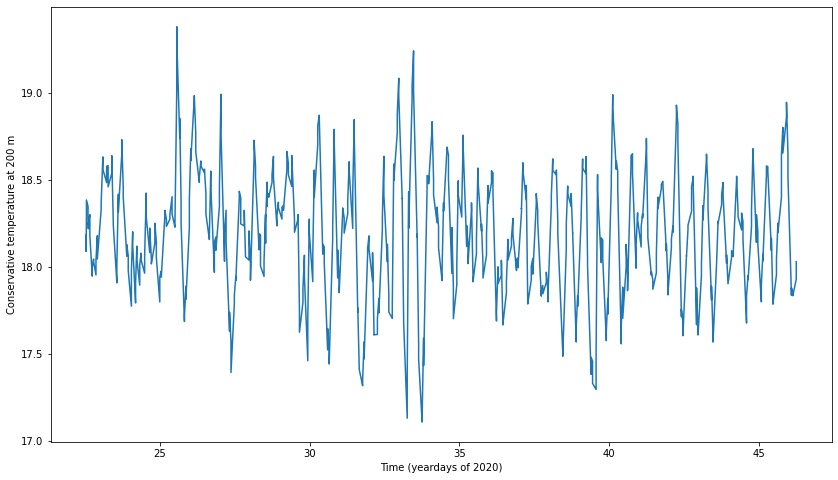

In [3]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(df.time_yday, df.temp_200m)
ax.set(xlabel='Time (yeardays of 2020)', ylabel='Conservative temperature at 200 m')

In [4]:
def tidal_analysis(t, x, T=(12.4206), detrend=True):
    """
    This function performs a harmonic analysis of timeseries x for a single
    or multiple tidal constituents including removal of trend and time-mean.
    :param t: time (yearday)
    :param x: variable (any units)
    :param T: tidal periods (hours) (T1,T2,T3,...) default: 12.4206 (M2)
    :detrend:  switch to remove trend as well as time-mean. Default=True
    :returns:
    
    xtrend: variable time-mean (same units as x)
            and variable trend (same units as x / same units as t)
    xamp:   amplitude of each tidal constituent (same units as x)
    xph:    phase of each tidal constituent (radians)
    xts:    timeseries of each tidal constituent (same units as x)
    xr:     residual timeseries (same units as x)
    stats:  regression statistics
             (R-square statistic, F statistic, p value, error variance)
    
    Original matlab function by Rob Hall (Aug 2014)
    Converted to Python by Callum Rollo (Sep 2020)
    """
    # Convert tidal periods to days
    T_days = T/24
    return t

I hope you found this notebook useful. Please direct any queries to c.rollo@uea.ac.uk